# Data import and respondent categories

In [2]:
import matplotlib
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

results = pd.read_csv('./questionnaire-results.tsv', '\t')

In [3]:
# Functions to select entries with a given job from the dataset
# Choices in the questionnaire were :
# 'Architecte et développeur', 'Développeur', 'Architecte', 'Consultant'

def select_entries_with_job(data, selected_names, notin = False):
    results_with_job_in_selected_names = data[results.columns[2]].isin(selected_names)
    cond = ~results_with_job_in_selected_names if notin else results_with_job_in_selected_names
    return data.loc[cond]


def architects(results):
    return select_entries_with_job(results, ['Architecte'])

def developers(results):
    return select_entries_with_job(results, ['Développeur'])

def both_architect_and_developers(results):
    return select_entries_with_job(results, ['Architecte et développeur'])

def consultants(results):
    return select_entries_with_job(results, ['Consultant'])

def other_jobs(results):
    return select_entries_with_job(results, ['Autre'])

In [4]:
# Functions to select entries with a given number of VM from the dataset
# Choices in the questionnaire were :
# 'Moins de 100', 'Entre 100 et 500', 'Entre 500 et 1000', 'Entre 1000 et 3000', 'Plus de 3000', 'Je ne sais pas'

def select_entries_with_vm(results, number_of_vm, notin = False):
    results_with_selected_number_of_vm = results[results.columns[4]] == number_of_vm
    cond = ~results_with_selected_number_of_vm if notin else results_with_selected_number_of_vm
    return results.loc[cond]

def lt_100_vm(results):
    return select_entries_with_vm(results, 'Moins de 100')

def bt_100_and_500_vm(results):
    return select_entries_with_vm(results, 'Entre 100 et 500')

def bt_500_and_1000_vm(results):
    return select_entries_with_vm(results, 'Entre 500 et 1000')

def bt_1000_and_3000_vm(results):
    return select_entries_with_vm(results, 'Entre 1 000 et 3 000')

def mt_3000_vm(results):
    return select_entries_with_vm(results, 'Plus de 3 000')

def dont_know_vm(results):
    return select_entries_with_vm(results, 'Je ne sais pas')

## Populations

In [35]:
def split_by_role(data):
    return {
        'All': [len(data)],
        'Architects': [len(architects(data))],
        'Developers': [len(developers(data))],
        'Archi & Devs': [len(both_architect_and_developers(data))],
        'Consultants': [len(consultants(data))],
        'Others': [len(other_jobs(data))]
    }

def split_by_vm_size(data):
    return {
        '< 100': [len(lt_100_vm(data))],
        '100 < n < 500': [len(bt_100_and_500_vm(data))],
        '500 < n < 1k': [len(bt_500_and_1000_vm(data))],
        '1k < n < 3k': [len(bt_1000_and_3000_vm(data))],
        '> 3k': [len(mt_3000_vm(data))],
        'Don\'t know': [len(dont_know_vm(data))]
    }

population_roles_df = pd.DataFrame(data=split_by_role(results))
population_vm_df = pd.DataFrame(data=split_by_vm_size(results))

print(population_roles_df)
print()
print(population_vm_df)

   All  Architects  Developers  Archi & Devs  Consultants  Others
0   53          10           9            18           12       4

   < 100  100 < n < 500  500 < n < 1k  1k < n < 3k  > 3k  Don't know
0     18              8             5            4     8          10


## Utility functions

In [19]:
def flatten_results(entries):
    series = entries.copy().str.split('; ').apply(pd.Series).unstack().dropna().reset_index(drop=True)
    return series.rename(entries.name)

def with_percentage_series_size(series):
    return with_percentage(series, len(series))

def with_percentage_respondants(series, respondants_count):
    return with_percentage(series, respondants_count)

def with_percentage_respondents_flatten(series):
    return with_percentage(flatten_results(series), len(series))
    
def with_percentage(series, sample_size):
    df = series.to_frame(series.name)
    df['percentage'] = df.groupby([series.name])[series.name].transform(lambda x: len(x)) / sample_size * 100
    return df.drop_duplicates().sort_values(by=['percentage'], ascending=False).reset_index()

# weights to normalize percentage per response based on the job of respondents
def compute_weights_along_job(df):
    job_col = results.columns[2]
    weights = df[job_col].to_frame(job_col)
    weights['value'] = weights.groupby([job_col])[job_col].transform(lambda x: len(x))
    weights = weights.drop_duplicates().reset_index()
    weights['value'] = weights['value'].map(lambda x: weights['value'].max() / x)
    return weights.set_index(job_col).T.drop(['index'])

def flatten_and_compute_percentage_weighted_on_roles(df, col_for_percentage, ignore_others=False):
    job_col = results.columns[2]
    data = df[[col_for_percentage, job_col]].dropna()
    
    roles_to_include = [
        architects(data),
        developers(data),
        both_architect_and_developers(data),
        consultants(data)
    ]
    if (not ignore_others):
        roles_to_include.append(other_jobs(data))
        
    data = pd.concat(roles_to_include)
    weights = compute_weights_along_job(data)
    sample_size = pd.Series(roles_to_include).map(lambda x: len(x)).max() * len(roles_to_include)
    
    data = splitDataFrameList(data, col_for_percentage, '; ')
    data['percentage'] = data.groupby([col_for_percentage, job_col])[job_col]\
        .transform(lambda x: len(x) * weights[x.loc[x.first_valid_index()]].value) / sample_size * 100
    data = data.drop_duplicates()
    data['percentage'] = data.groupby([col_for_percentage])['percentage']\
        .transform(lambda x: x.sum())
    
    return data[[col_for_percentage, 'percentage']]\
        .drop_duplicates()\
        .sort_values(by=['percentage'], ascending=False)\
        .reset_index()


def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df
    
def get_data_per_role(df, question):
    job_col = results.columns[2]
    dataset = df[[question, job_col]].dropna()

    data_overall = dataset
    data_archi = architects(dataset)
    data_dev = developers(dataset)
    data_archi_dev = both_architect_and_developers(dataset)
    data_consultants = consultants(dataset)
    data_others = other_jobs(dataset)
    
    return pd.concat([data_overall, data_archi, data_dev, data_archi_dev, data_consultants, data_others])

def get_data_per_role_with_percentage(df, question):
    job_col = results.columns[2]
    dataset = df[[question, job_col]].dropna()
    
    def with_perc_util(data):
        d = data[question].dropna()
        return with_percentage_respondents_flatten(d)

    data_overall = with_perc_util(dataset)
    data_overall['role'] = 'Average'
    data_archi = with_perc_util(architects(dataset))
    data_archi['role'] = 'Architects'
    data_dev = with_perc_util(developers(dataset))
    data_dev['role'] = 'Developers'
    data_archi_dev = with_perc_util(both_architect_and_developers(dataset))
    data_archi_dev['role'] = 'Archi & Dev'
    data_consultants = with_perc_util(consultants(dataset))
    data_consultants['role'] = 'Consultants'
    data_others = with_perc_util(other_jobs(dataset))
    data_others['role'] = 'Other roles'
    
    return pd.concat([data_overall, data_archi, data_dev, data_archi_dev, data_consultants, data_others])

In [7]:
# Utility functions to display data

def barplot_percentage(data, question, title_suffix='', hue=None, col=None, with_percentage=True):
    g = sns.barplot(x='percentage', y=question, data=data, palette = 'Greys', hue=hue)
    g.set_title(question + str(title_suffix))
    g.set_ylabel(None)
    g.set_xbound(upper=max(data.percentage) + 10)
    
    if with_percentage:
        for i, row in data.iterrows():
            g.text(row.percentage + 1, i + 0.1, '{0:.2f}%'.format(round(row.percentage,2)))
        
    return g

def catplot_percentage(data, question, col):
    g = sns.catplot('percentage', question, data=data, col=col, kind='bar', col_wrap=3, palette = 'Greys')
    for (i, axes) in enumerate(g.axes):
        axes.set_ylabel(None)
    return g

def boxplot(data):
    print('Sample size: ' + str(len(data)))
    print('Scale was an integer in [0;5]')
    print('Mean: ' + str(data.mean()))
    print('Median: ' + str(data.median()))
    print('Min: ' + str(data.min()))
    print('Max: ' + str(data.max()))
    matplotlib.pyplot.boxplot(x = data)

# Chosen dataset to generate the graphs
Uncomment a ligne to change the dataset to study and then generate all graphs again.

In [8]:
all_res = results
archi = architects(results)
devs = developers(results)
archi_dev = both_architect_and_developers(results)
consult = consultants(results)
other_job = other_jobs(results)
mini_vm = lt_100_vm(results)
small_vm = bt_100_and_500_vm(results)
medium_vm = bt_500_and_1000_vm(results)
big_vm = bt_1000_and_3000_vm(results)
huge_vm = mt_3000_vm(results)
other_vm = dont_know_vm(results)
# print(studied_data_set)

studied_data_set = results

print('The number of respondant in the data set that is being studied is: ' + str(studied_data_set[studied_data_set.columns[0]].size))

The number of respondant in the data set that is being studied is: 53


# Most important problems

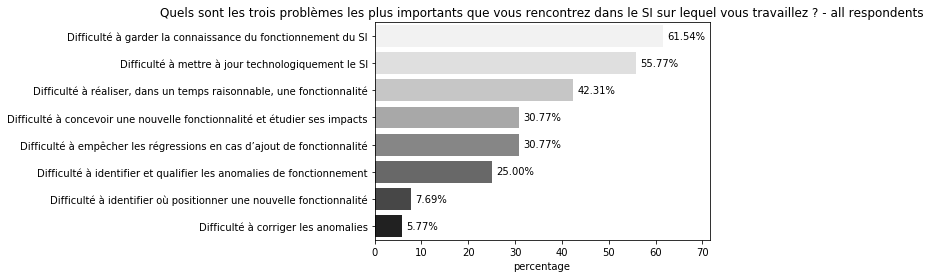

In [9]:
question = studied_data_set.columns[5]

def clean_dataset_for_major_problems(source):
    question = studied_data_set.columns[5]
    dataset = source[question].dropna()
    return with_percentage_respondants(flatten_results(dataset), len(dataset))

major_problems = clean_dataset_for_major_problems(studied_data_set)

g = barplot_percentage(major_problems, question, ' - all respondents')

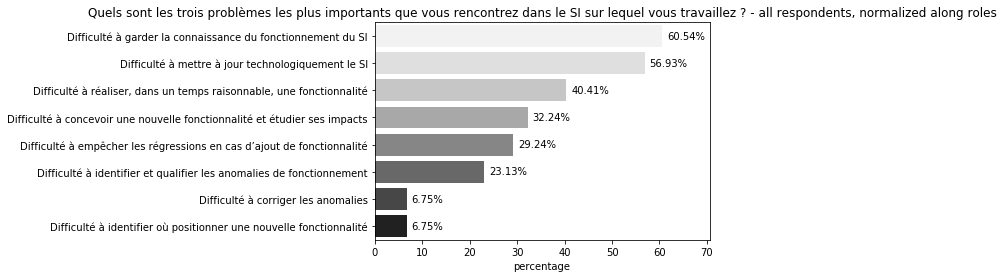

In [10]:
question = studied_data_set.columns[5]

res = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
res_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
g = barplot_percentage(res, question, ' - all respondents, normalized along roles')

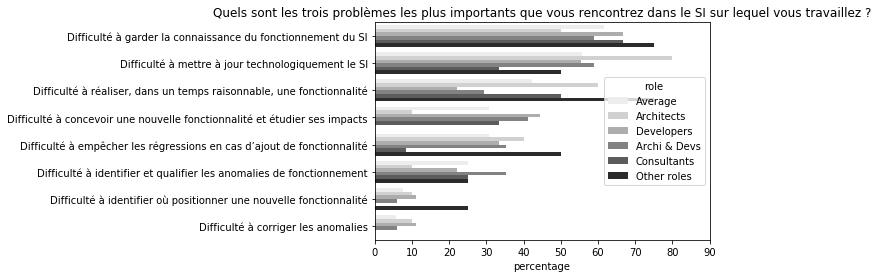

In [11]:
question = studied_data_set.columns[5]

major_problems_overall = clean_dataset_for_major_problems(results)
major_problems_overall['role'] = 'Average'
major_problems_archi = clean_dataset_for_major_problems(architects(results))
major_problems_archi['role'] = 'Architects'
major_problems_dev = clean_dataset_for_major_problems(developers(results))
major_problems_dev['role'] = 'Developers'
major_problems_archi_dev = clean_dataset_for_major_problems(both_architect_and_developers(results))
major_problems_archi_dev['role'] = 'Archi & Devs'
major_problems_consultants = clean_dataset_for_major_problems(consultants(results))
major_problems_consultants['role'] = 'Consultants'
major_problems_others = clean_dataset_for_major_problems(other_jobs(results))
major_problems_others['role'] = 'Other roles'

major_problems = pd.concat([major_problems_overall, major_problems_archi, major_problems_dev, major_problems_archi_dev, major_problems_consultants, major_problems_others])

g = barplot_percentage(major_problems, question, hue='role', with_percentage=False)

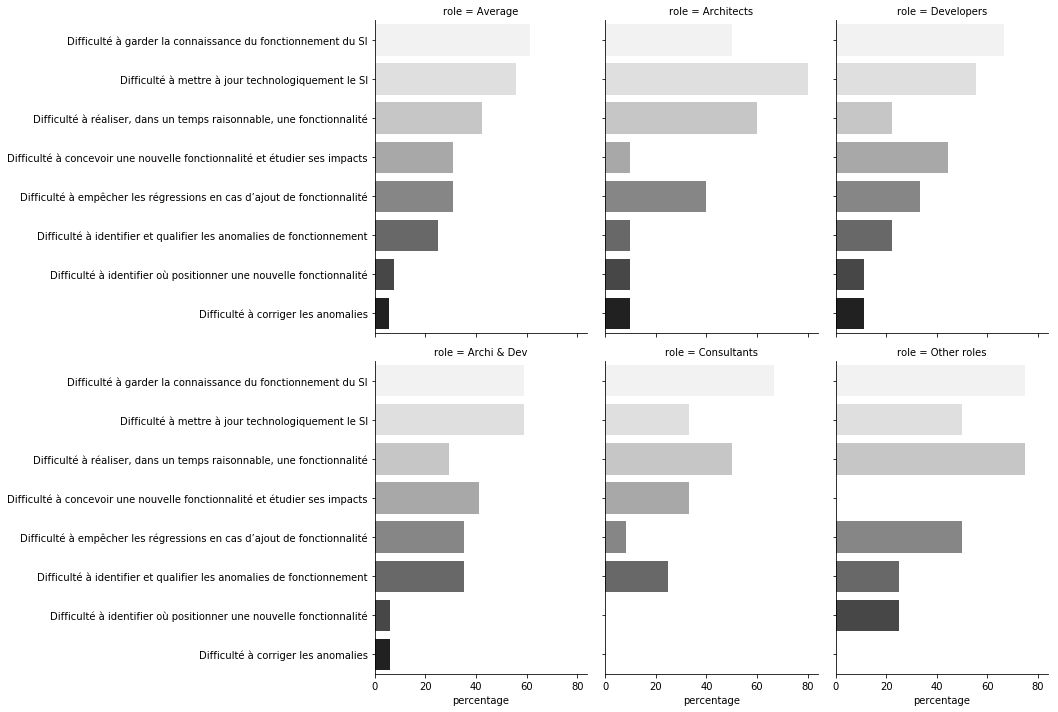

In [12]:
question = studied_data_set.columns[5]

major_problems_overall = clean_dataset_for_major_problems(results)
major_problems_overall['role'] = 'Average'
major_problems_archi = clean_dataset_for_major_problems(architects(results))
major_problems_archi['role'] = 'Architects'
major_problems_dev = clean_dataset_for_major_problems(developers(results))
major_problems_dev['role'] = 'Developers'
major_problems_archi_dev = clean_dataset_for_major_problems(both_architect_and_developers(results))
major_problems_archi_dev['role'] = 'Archi & Dev'
major_problems_consultants = clean_dataset_for_major_problems(consultants(results))
major_problems_consultants['role'] = 'Consultants'
major_problems_others = clean_dataset_for_major_problems(other_jobs(results))
major_problems_others['role'] = 'Other roles'

major_problems = pd.concat([major_problems_overall, major_problems_archi, major_problems_dev, major_problems_archi_dev, major_problems_consultants, major_problems_others])

major_problems.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(major_problems, 'responses', 'role')

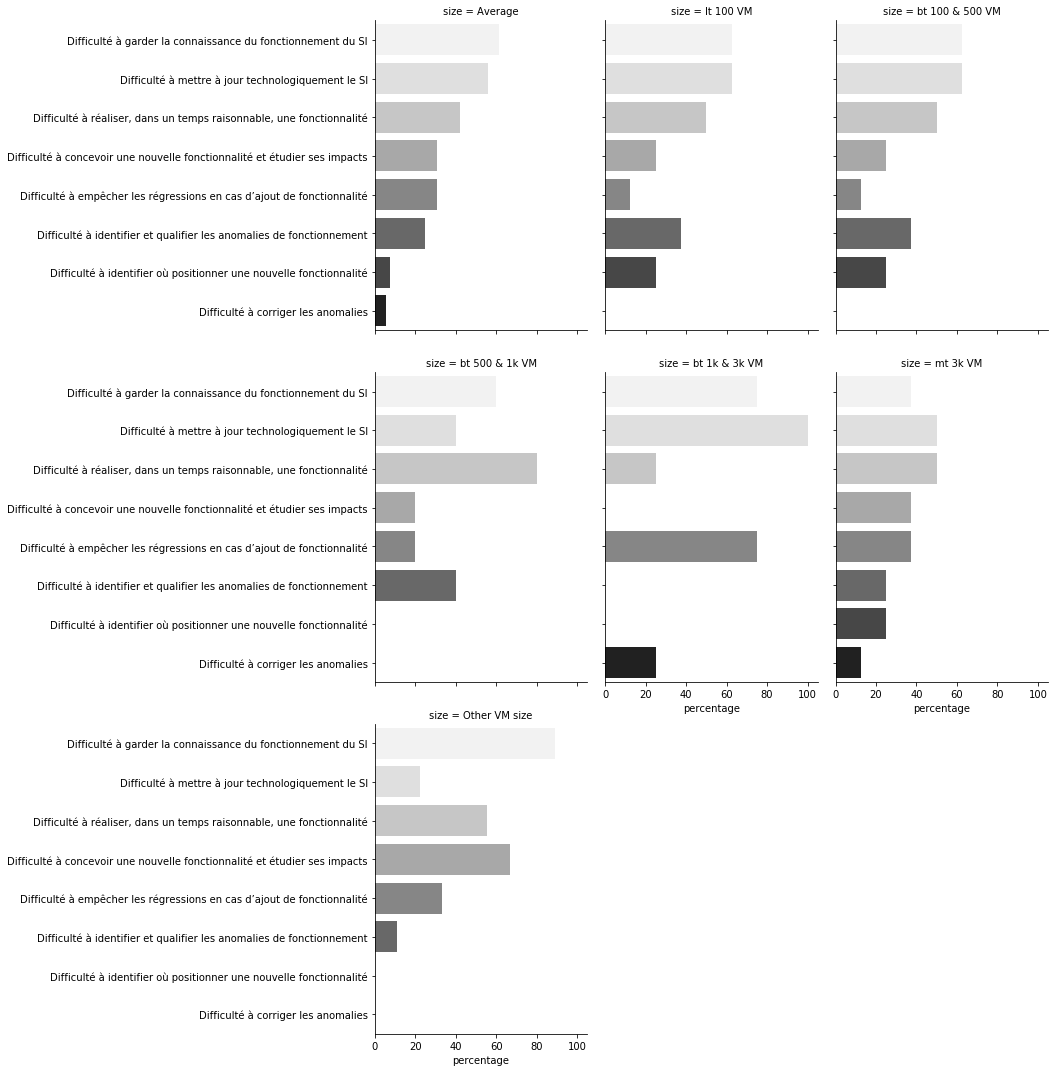

In [13]:
question = studied_data_set.columns[5]

major_problems_overall = clean_dataset_for_major_problems(results)
major_problems_overall['size'] = 'Average'
major_problems_mini = clean_dataset_for_major_problems(small_vm)
major_problems_mini['size'] = 'lt 100 VM'
major_problems_small = clean_dataset_for_major_problems(small_vm)
major_problems_small['size'] = 'bt 100 & 500 VM'
major_problems_medium = clean_dataset_for_major_problems(medium_vm)
major_problems_medium['size'] = 'bt 500 & 1k VM'
major_problems_big = clean_dataset_for_major_problems(big_vm)
major_problems_big['size'] = 'bt 1k & 3k VM'
major_problems_huge = clean_dataset_for_major_problems(huge_vm)
major_problems_huge['size'] = 'mt 3k VM'
major_problems_others = clean_dataset_for_major_problems(other_vm)
major_problems_others['size'] = 'Other VM size'

major_problems = pd.concat([major_problems_overall, major_problems_mini, major_problems_small, major_problems_medium, major_problems_big, major_problems_huge, major_problems_others])

major_problems.columns = ['index', 'responses', 'percentage', 'size']
g = catplot_percentage(major_problems, 'responses', 'size')

# Difficulté à garder la connaissance du SI

## Quel est votre degré de connaissance sur le SI sur lequel vous travaillez ?

Sample size: 53
Scale was an integer in [0;5]
Mean: 3.2264150943396226
Median: 3.0
Min: 1
Max: 5


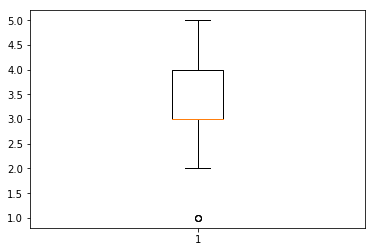

In [14]:
question = results.columns[6]
boxplot(studied_data_set[question])

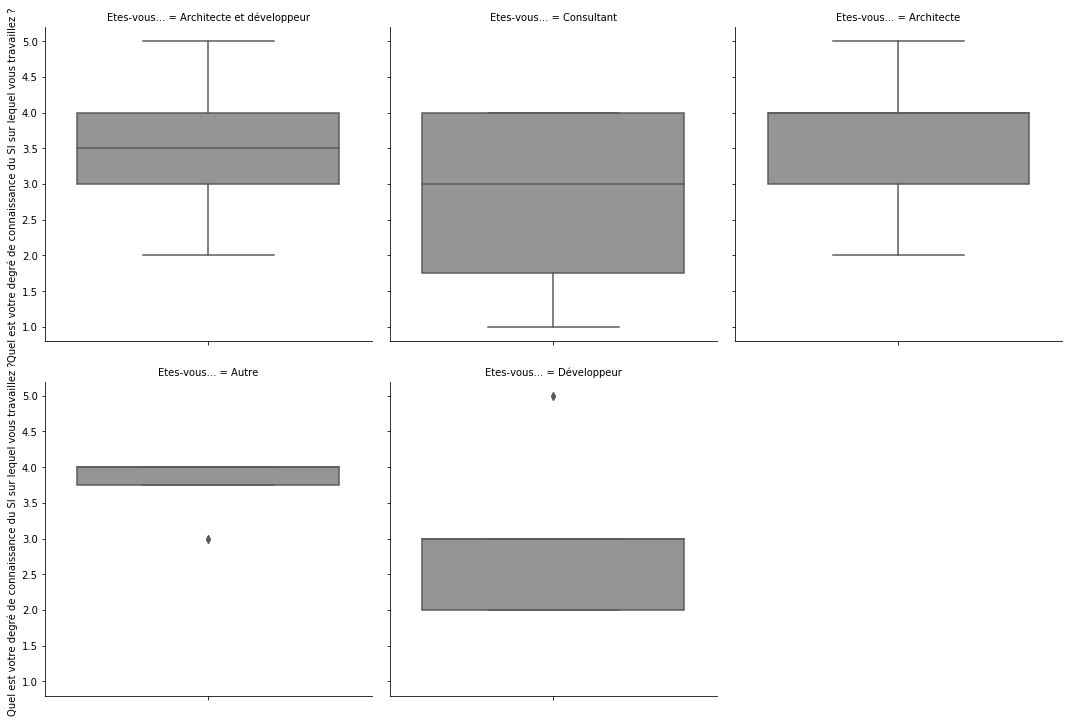

In [15]:
question = results.columns[6]
data = get_data_per_role(studied_data_set, question)

sns.catplot(y=question, data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Quelles sont les trois principales difficultés que vous avez à surmonter pour bien connaître votre SI ?

Quelles sont les trois principales difficultés que vous avez à surmonter pour bien connaître votre SI ?


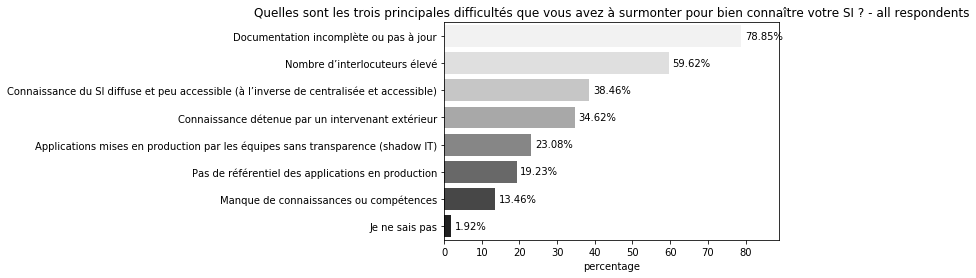

In [16]:
question = studied_data_set.columns[7]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))

g = barplot_percentage(data, question, ' - all respondents')

Quelles sont les trois principales difficultés que vous avez à surmonter pour bien connaître votre SI ?


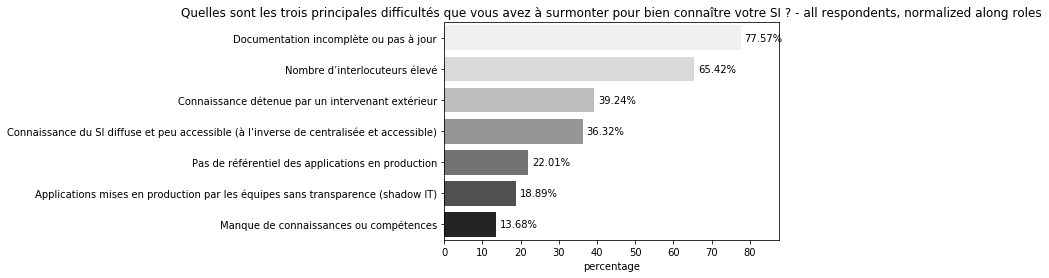

In [17]:
question = studied_data_set.columns[7]
print(question)

data = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)

g = barplot_percentage(data, question, ' - all respondents, normalized along roles')

Quelles sont les trois principales difficultés que vous avez à surmonter pour bien connaître votre SI ?


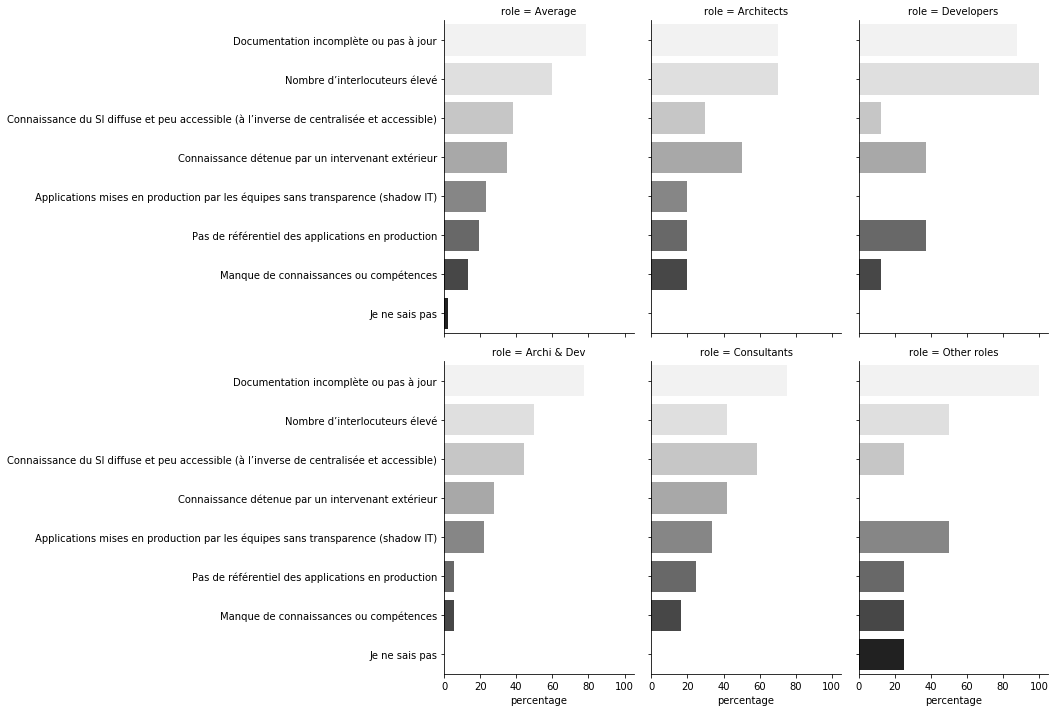

In [20]:
question = studied_data_set.columns[7]
print(question)

data = get_data_per_role_with_percentage(studied_data_set, question)

data.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(data, 'responses', 'role')

# Mise à jour technologique du SI

## A quel point vous est-il difficile de mettre à jour le SI ?

Sample size: 53
Scale was an integer in [0;5]
Mean: 2.9622641509433962
Median: 3.0
Min: 0
Max: 5


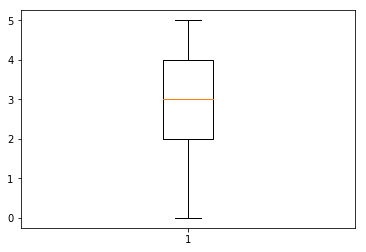

In [21]:
question = results.columns[32]
boxplot(studied_data_set[question])

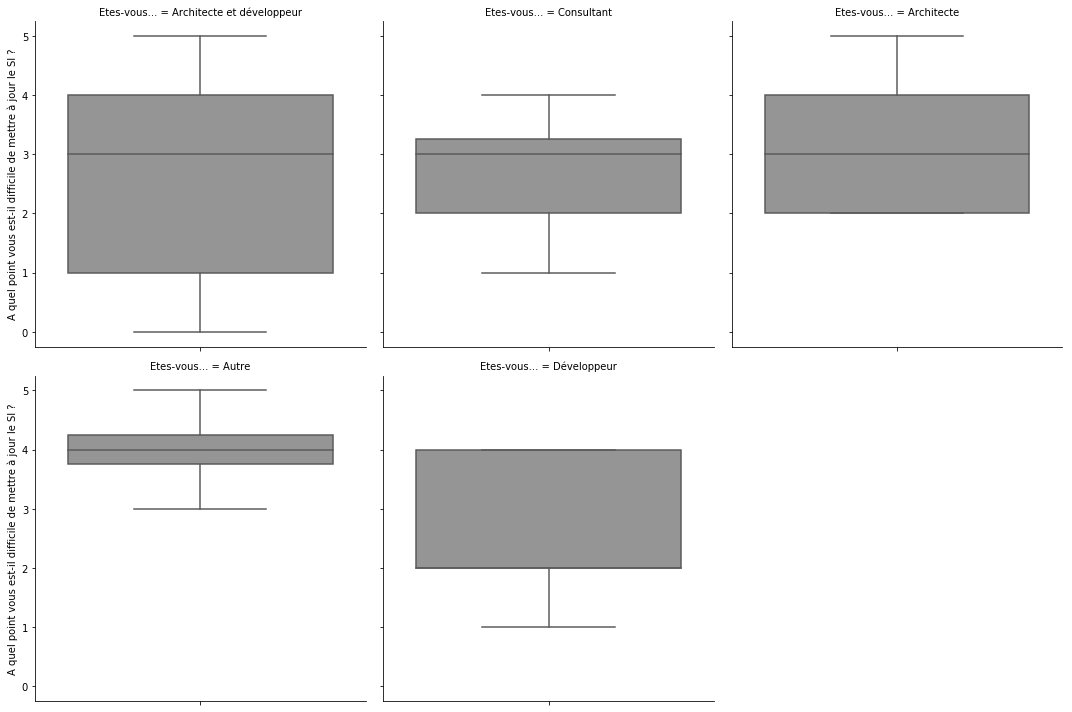

In [22]:
question = results.columns[32]
data = get_data_per_role(studied_data_set, question)

sns.catplot(y=question, data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Quels sont les trois facteurs qui freinent le plus votre capacité à mettre à jour le SI ?

Quels sont les trois facteurs qui freinent le plus votre capacité à mettre à jour le SI ?


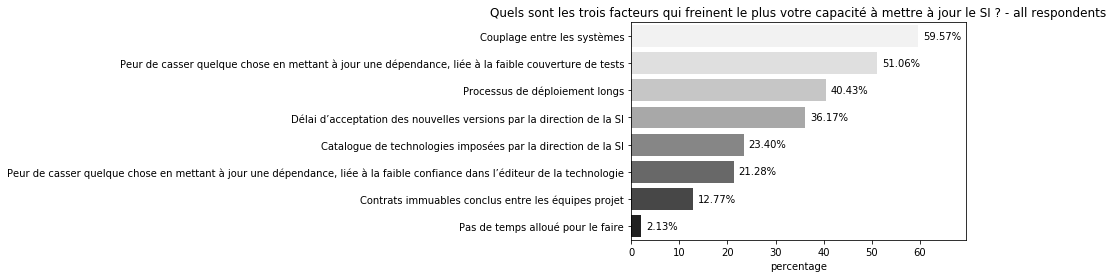

In [23]:
question = studied_data_set.columns[33]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))

g = barplot_percentage(data, question, ' - all respondents')

Quels sont les trois facteurs qui freinent le plus votre capacité à mettre à jour le SI ?


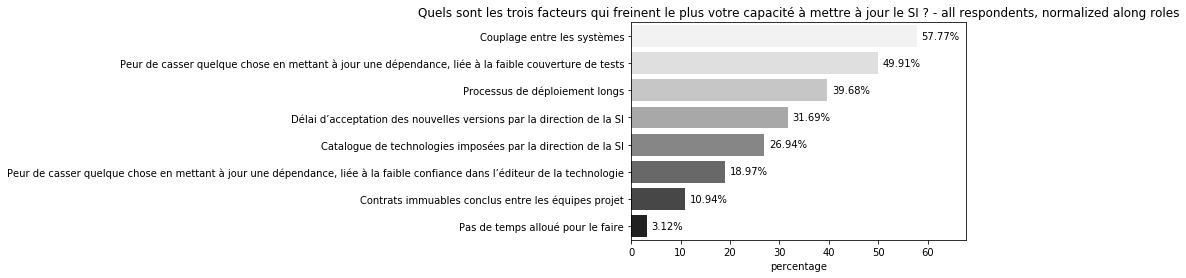

In [24]:
question = studied_data_set.columns[33]
print(question)

data = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)

g = barplot_percentage(data, question, ' - all respondents, normalized along roles')

Quels sont les trois facteurs qui freinent le plus votre capacité à mettre à jour le SI ?


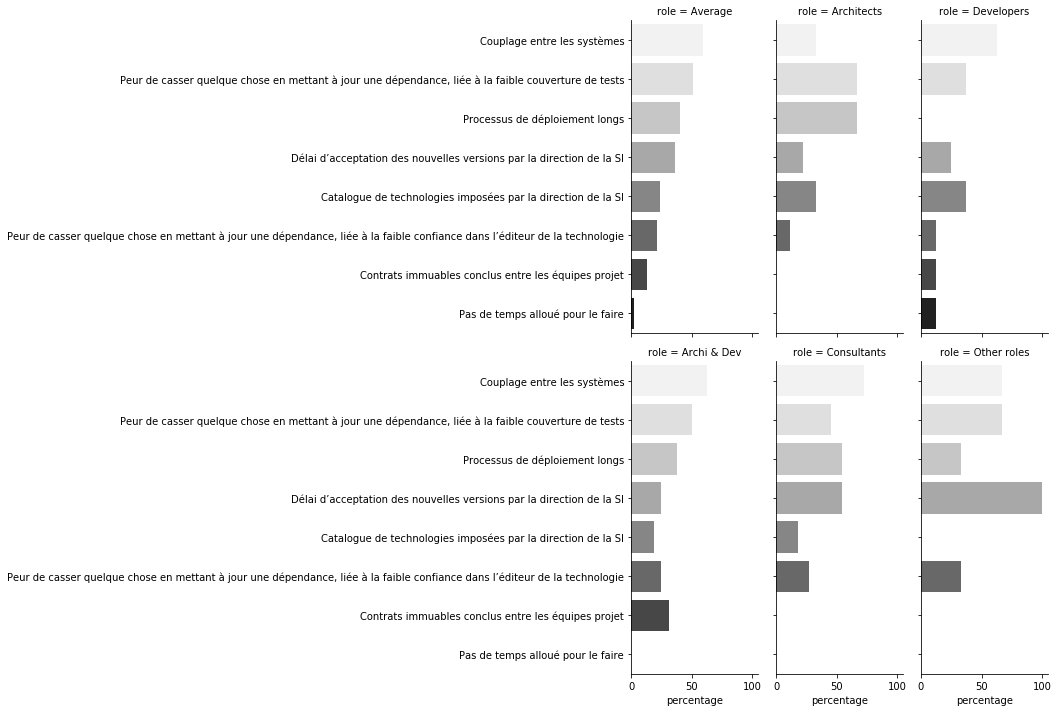

In [25]:
question = studied_data_set.columns[33]
print(question)

data = get_data_per_role_with_percentage(studied_data_set, question)

data.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(data, 'responses', 'role')

# Réalisation et implémentation

In [42]:
cond = results[results.columns[18]] == 'Oui'
real_with_imposed_techno = studied_data_set.loc[cond]
real_without_imposed_techno = studied_data_set.loc[~cond]

# print(pd.DataFrame(split_by_role(real_with_imposed_techno)))
# print(pd.DataFrame(split_by_role(real_without_imposed_techno)))

## Dans quelle mesure avez-vous les moyens de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?

Sample size: 31
Scale was an integer in [0;5]
Mean: 2.5161290322580645
Median: 3.0
Min: 0
Max: 4

Sample size: 22
Scale was an integer in [0;5]
Mean: 2.6363636363636362
Median: 3.0
Min: 1
Max: 5


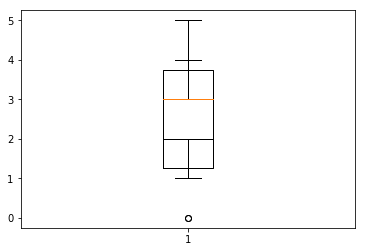

In [49]:
question = results.columns[17]
#boxplot(studied_data_set[question])
boxplot(real_with_imposed_techno[question])
print()
boxplot(real_without_imposed_techno[question])

Dans quelle mesure avez-vous les moyens de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?


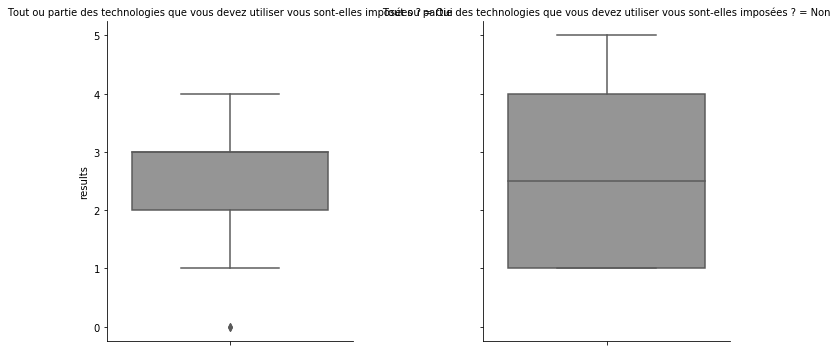

In [43]:
question = results.columns[17]
col = results.columns[18]
print(question)

data = studied_data_set.copy()
data['results'] = data[question]
data = data[['results', col]]

sns.catplot(y='results', data=data, kind='box', col=col, palette = 'Greys', col_wrap=3)

Dans quelle mesure avez-vous les moyens de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?


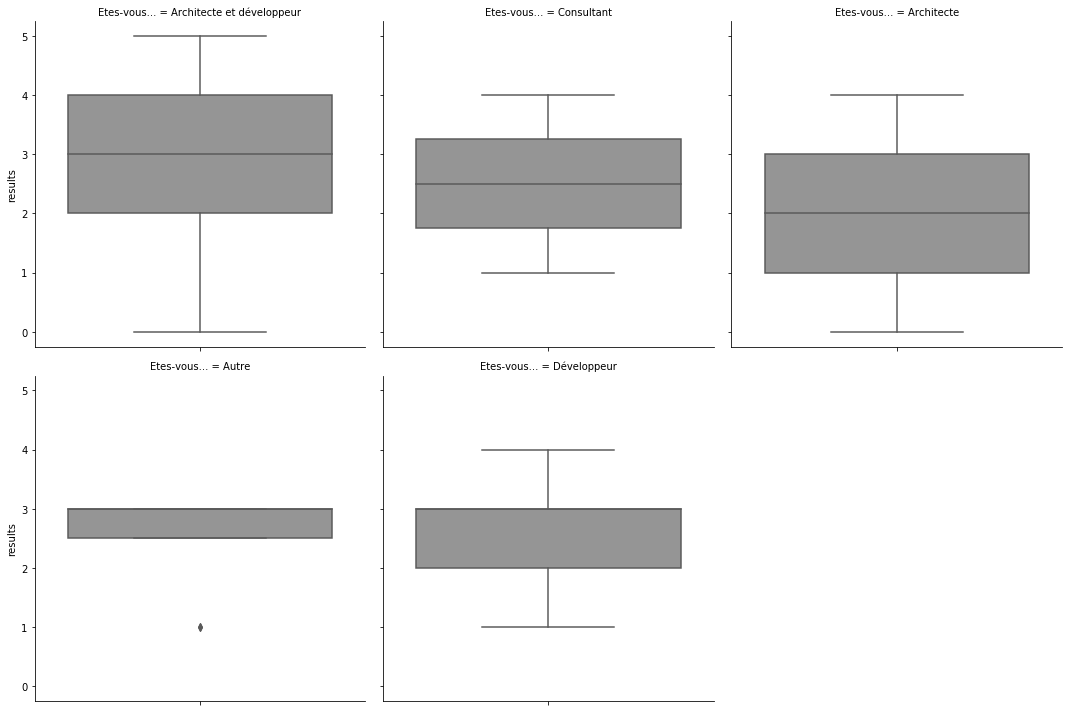

In [416]:
question = results.columns[17]
print(question)
data = get_data_per_role(studied_data_set, question)
data['results'] = data[question]
data = data[['results', results.columns[2]]]

sns.catplot(y='results', data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Tout ou partie des technologies que vous devez utiliser vous sont-elles imposées ?

Tout ou partie des technologies que vous devez utiliser vous sont-elles imposées ?


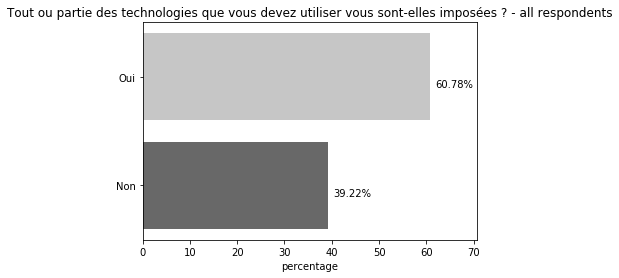

In [419]:
question = studied_data_set.columns[18]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))
g = barplot_percentage(data, question, ' - all respondents')

data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
#g = barplot_percentage(data_normalized, question, ' - all respondents, normalized along roles')

## Dans quelle mesure diriez-vous que les technologies qui vous sont imposées vous ralentissent et/ou limitent vos possibilités ?

All
Sample size: 52
Scale was an integer in [0;5]
Mean: 2.5
Median: 3.0
Min: 0.0
Max: 5.0

Imposed technologies
Sample size: 31
Scale was an integer in [0;5]
Mean: 2.935483870967742
Median: 3.0
Min: 1.0
Max: 5.0

No imposed technologies
Sample size: 21
Scale was an integer in [0;5]
Mean: 1.8571428571428572
Median: 2.0
Min: 0.0
Max: 4.0


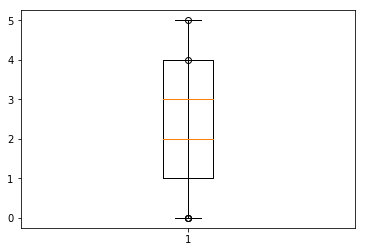

In [52]:
question = results.columns[19]
print('All')
boxplot(studied_data_set[question].dropna())
print('\nImposed technologies')
boxplot(real_with_imposed_techno[question].dropna())
print('\nNo imposed technologies')
boxplot(real_without_imposed_techno[question].dropna())

Dans quelle mesure diriez-vous que les technologies qui vous sont imposées vous ralentissent et/ou limitent vos possibilités ?


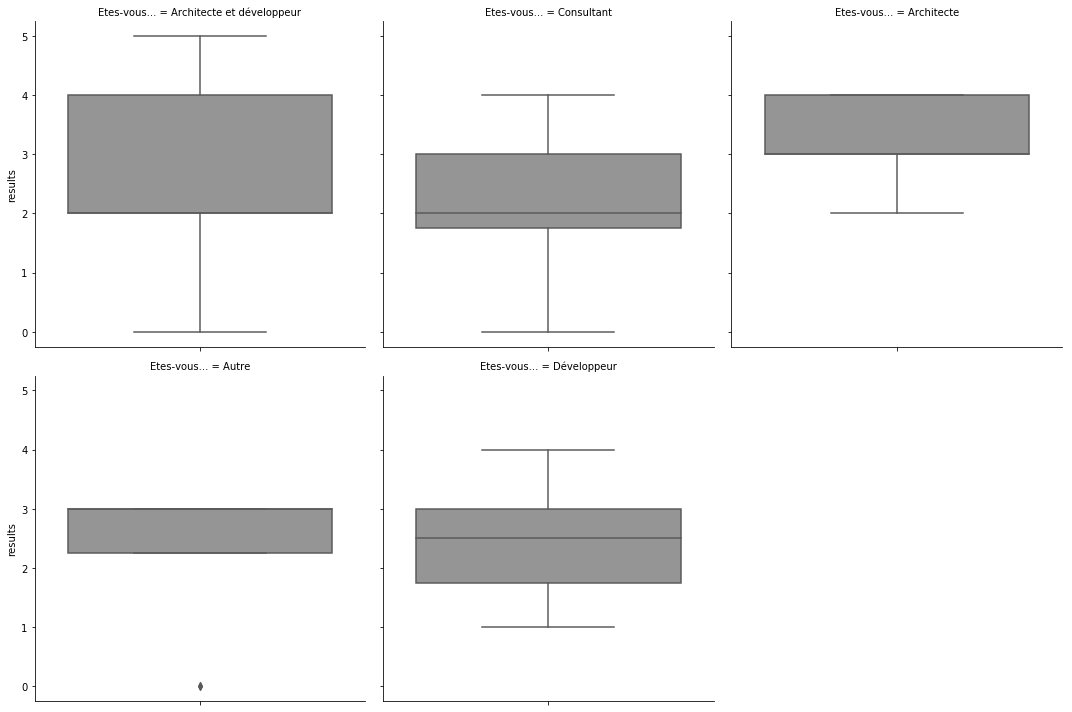

In [425]:
question = results.columns[19]
print(question)
data = get_data_per_role(studied_data_set, question)
data['results'] = data[question]
data = data[['results', results.columns[2]]]

sns.catplot(y='results', data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Dans le cas où vous consommez une API, quelle part du temps de développement consacrez-vous à réécrire les contrats métier (rôles utilisateurs, modèles de données, ordre des opérations, droits d’accès, règles de validation) déjà écrits sur le serveur ?

Dans le cas où vous consommez une API, quelle part du temps de développement consacrez-vous à réécrire les contrats métier (rôles utilisateurs, modèles de données, ordre des opérations, droits d’accès, règles de validation) déjà écrits sur le serveur ?


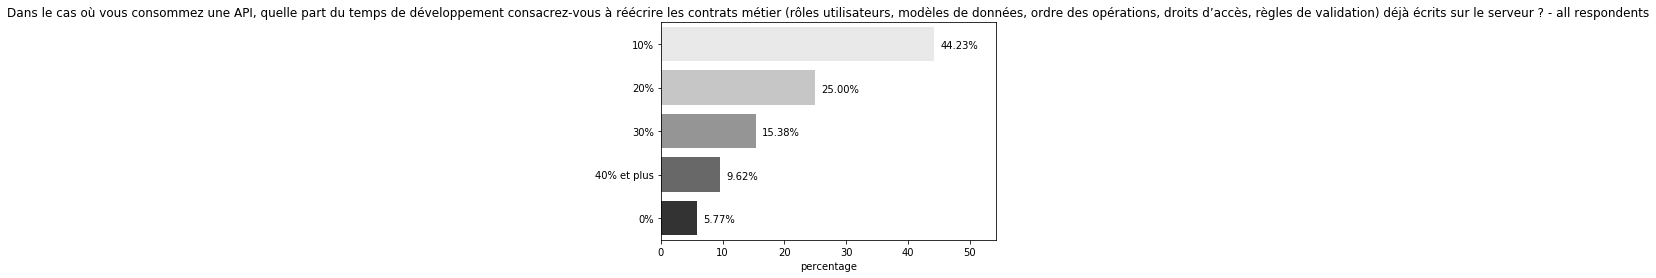

In [432]:
question = studied_data_set.columns[20]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))
g = barplot_percentage(data, question, ' - all respondents')

#data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
#g = barplot_percentage(data_normalized, question, ' - all respondents, normalized along roles')

Dans le cas où vous consommez une API, quelle part du temps de développement consacrez-vous à réécrire les contrats métier (rôles utilisateurs, modèles de données, ordre des opérations, droits d’accès, règles de validation) déjà écrits sur le serveur ?


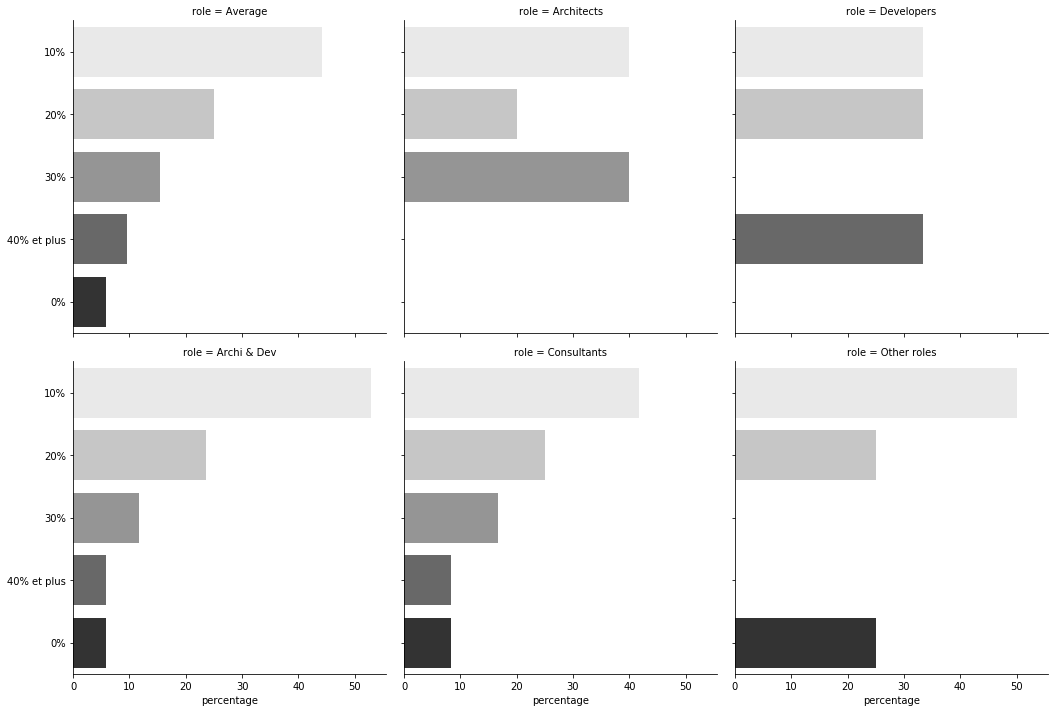

In [429]:
question = studied_data_set.columns[20]
print(question)

data = get_data_per_role_with_percentage(studied_data_set, question)

data.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(data, 'responses', 'role')

## Quels sont les 3 facteurs qui vous empêchent le plus d’être à même de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?

Quels sont les 3 facteurs qui vous empêchent le plus d’être à même de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?


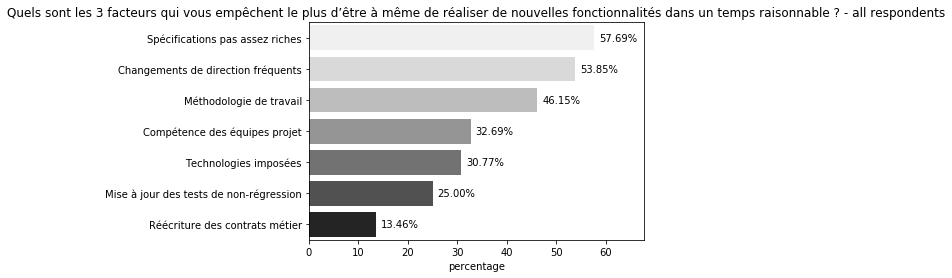

In [433]:
question = studied_data_set.columns[21]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))
g = barplot_percentage(data, question, ' - all respondents')

#data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
#g = barplot_percentage(data_normalized, question, ' - all respondents, normalized along roles')

Quels sont les 3 facteurs qui vous empêchent le plus d’être à même de réaliser de nouvelles fonctionnalités dans un temps raisonnable ?


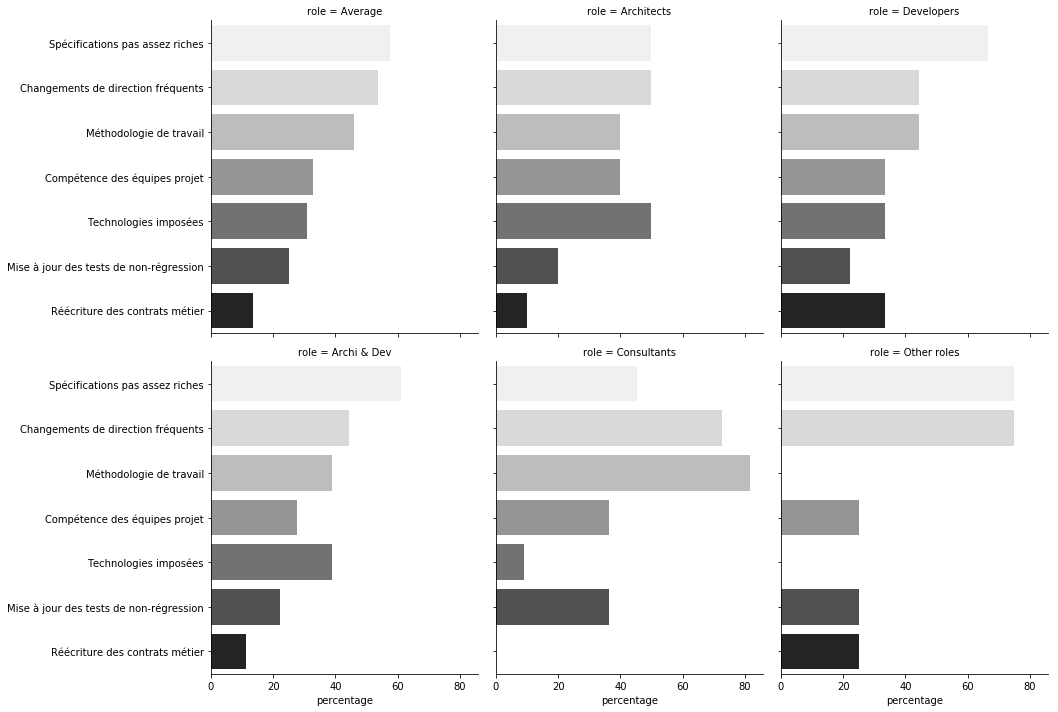

In [434]:
question = studied_data_set.columns[21]
print(question)

data = get_data_per_role_with_percentage(studied_data_set, question)

data.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(data, 'responses', 'role')

# Conception de nouvelles fonctionnalités et analyse d’impact

## A quel point est-il complexe d’ajouter une fonctionnalité dans votre SI ?

A quel point est-il complexe d’ajouter une fonctionnalité dans votre SI ?
Sample size: 53
Scale was an integer in [0;5]
Mean: 2.660377358490566
Median: 3.0
Min: 0
Max: 5


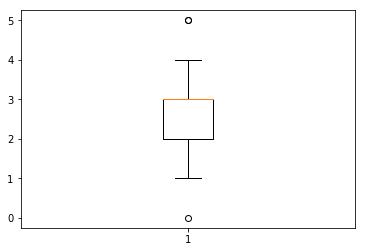

In [439]:
question = results.columns[11]
print(question)
boxplot(studied_data_set[question].dropna())

A quel point est-il complexe d’ajouter une fonctionnalité dans votre SI ?


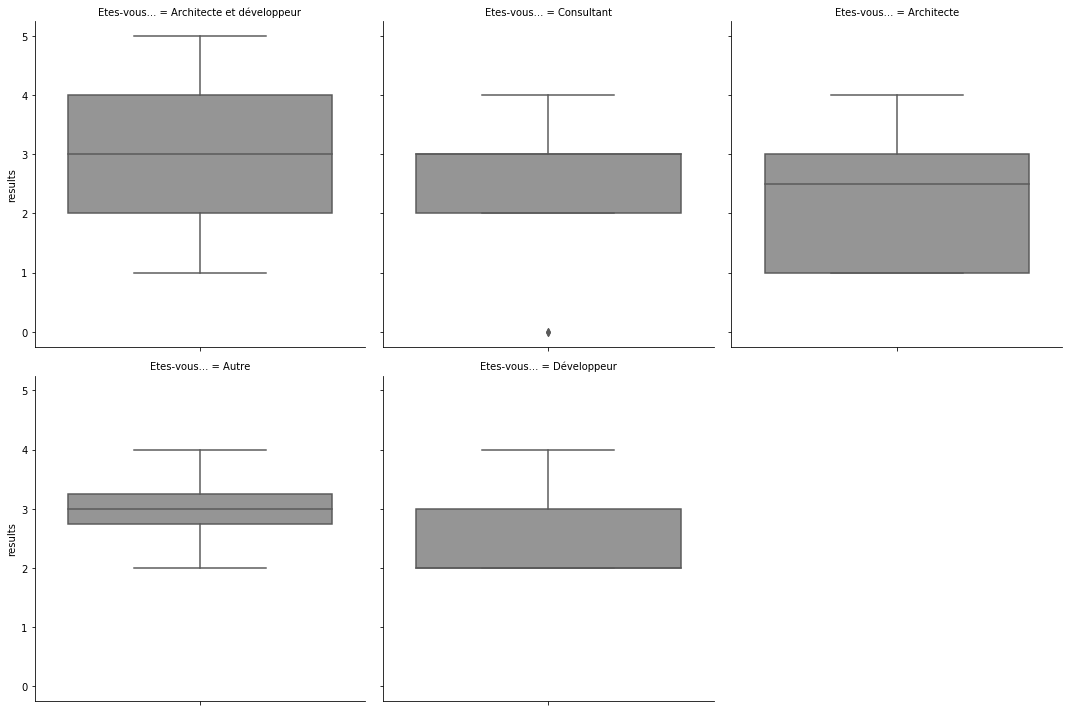

In [440]:
question = results.columns[11]
print(question)
data = get_data_per_role(studied_data_set, question)
data['results'] = data[question]
data = data[['results', results.columns[2]]]

sns.catplot(y='results', data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Dans quelle mesure avez-vous les outils et informations nécessaires à votre disposition pour mesurer l’impact technique qu’aura l’ajout d’une fonctionnalité à votre SI ?

Dans quelle mesure avez-vous les outils et informations nécessaires à votre disposition pour mesurer l’impact technique qu’aura l’ajout d’une fonctionnalité à votre SI ?
Sample size: 53
Scale was an integer in [0;5]
Mean: 2.2264150943396226
Median: 2.0
Min: 0
Max: 5


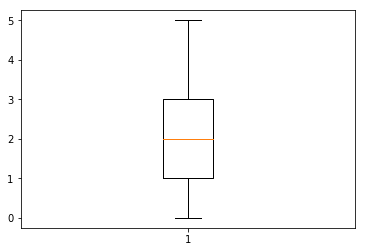

In [441]:
question = results.columns[12]
print(question)
boxplot(studied_data_set[question].dropna())

Dans quelle mesure avez-vous les outils et informations nécessaires à votre disposition pour mesurer l’impact technique qu’aura l’ajout d’une fonctionnalité à votre SI ?


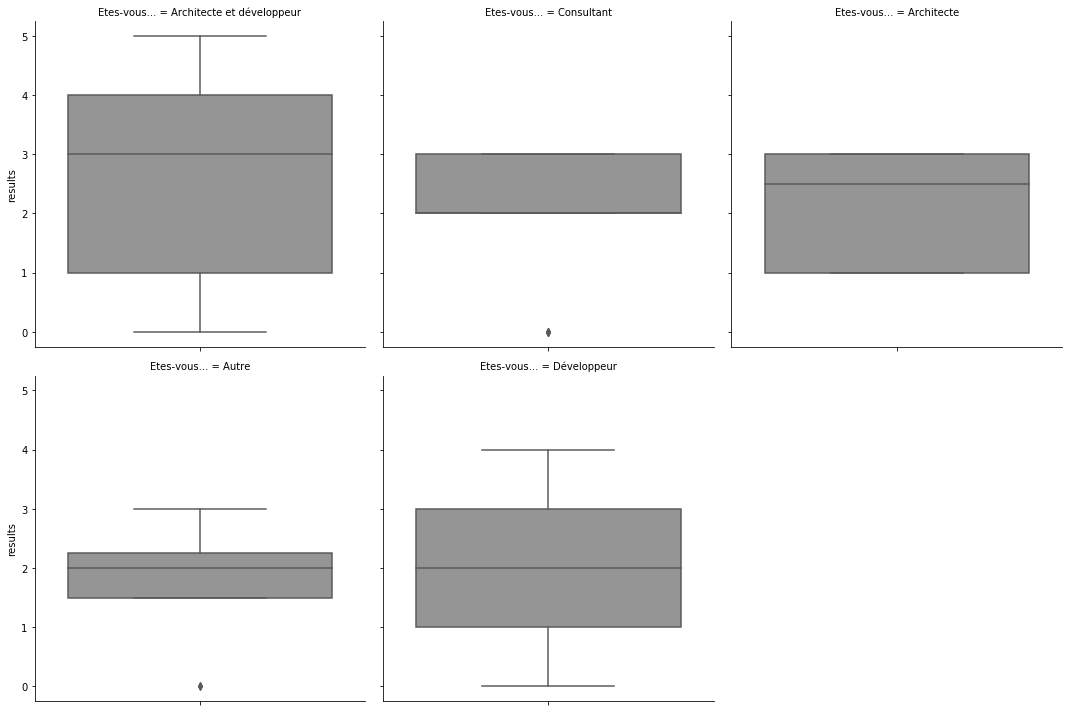

In [442]:
question = results.columns[12]
print(question)
data = get_data_per_role(studied_data_set, question)
data['results'] = data[question]
data = data[['results', results.columns[2]]]

sns.catplot(y='results', data=data, kind='box', col=results.columns[2], palette = 'Greys', col_wrap=3)

## Quels sont les trois facteurs qui vous ralentissent le plus lorsque vous concevez de nouvelles fonctionnalités ?

Quels sont les trois facteurs qui vous ralentissent le plus lorsque vous concevez de nouvelles fonctionnalités ?


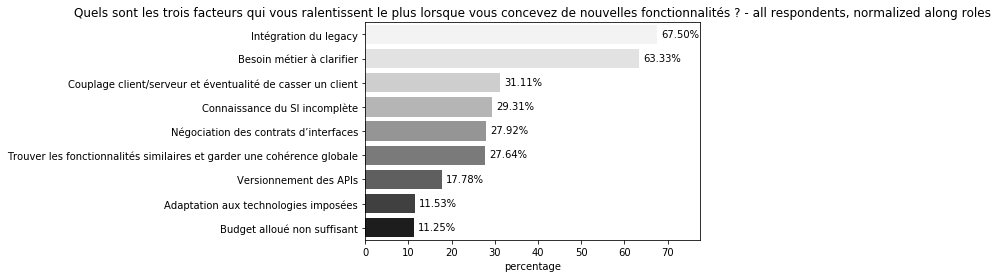

In [447]:
question = studied_data_set.columns[13]
print(question)

#dataset = studied_data_set[question].dropna()
#data = with_percentage_respondants(flatten_results(dataset), len(dataset))
#g = barplot_percentage(data, question, ' - all respondents')

data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
g = barplot_percentage(data_normalized, question, ' - all respondents, normalized along roles')

Quels sont les trois facteurs qui vous ralentissent le plus lorsque vous concevez de nouvelles fonctionnalités ?


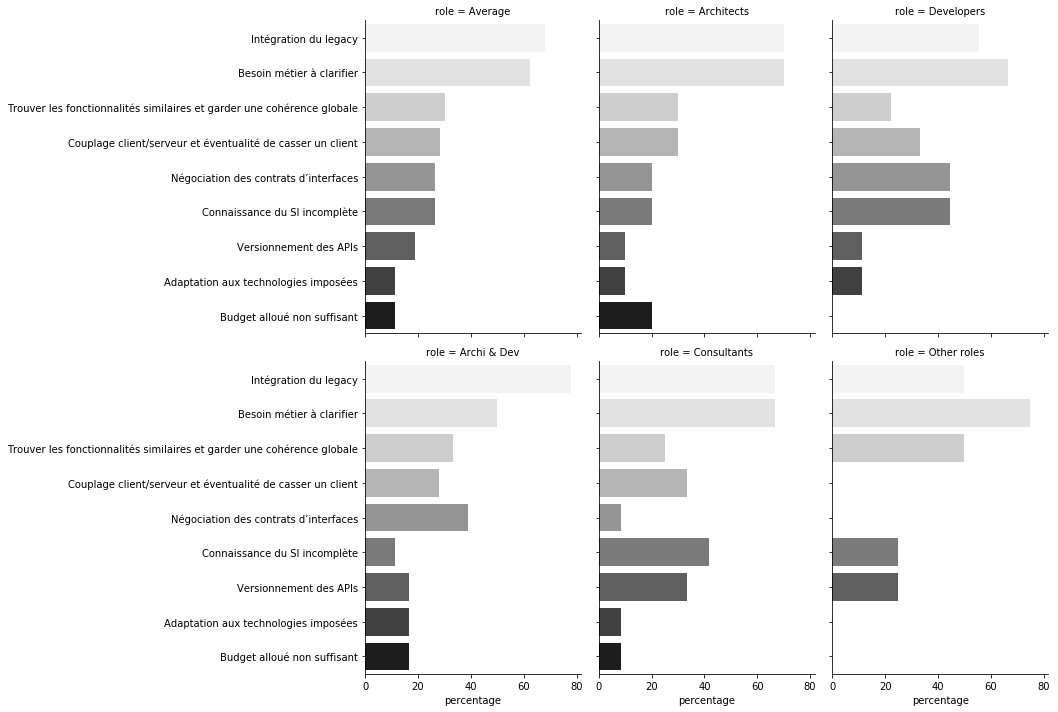

In [448]:
question = studied_data_set.columns[13]
print(question)

data = get_data_per_role_with_percentage(studied_data_set, question)

data.columns = ['index', 'responses', 'percentage', 'role']
g = catplot_percentage(data, 'responses', 'role')

## Lorsque vous vous rendez compte que l’ajout d’une nouvelle fonctionnalité nécessite de créer une nouvelle version majeure de l’API, préférez-vous .. ?

Lorsque vous vous rendez compte que l’ajout d’une nouvelle fonctionnalité nécessite de créer une nouvelle version majeure de l’API, préférez-vous .. ?


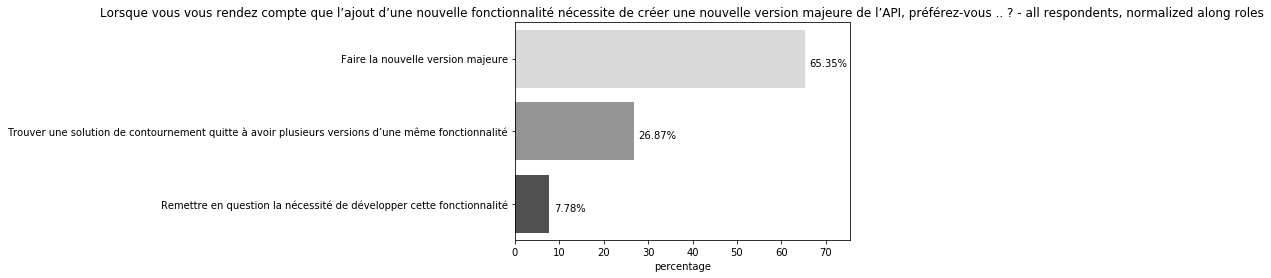

In [449]:
question = studied_data_set.columns[14]
print(question)

#dataset = studied_data_set[question].dropna()
#data = with_percentage_respondants(flatten_results(dataset), len(dataset))
#g = barplot_percentage(data, question, ' - all respondents')

data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
g = barplot_percentage(data_normalized, question, ' - all respondents, normalized along roles')

## Dans une architecture micro-services, plus les responsabilités sont isolées, plus le nombre de micro-services augmente. Par conséquent, il devient fréquent qu'un autre service, souvent front-end, soit client de l'API de plusieurs micro-services afin d'agréger l'information dispersée dans le SI. En tant qu'architecte du SI, vous prenez en compte cette problématique en ...

Dans une architecture micro-services, plus les responsabilités sont isolées, plus le nombre de micro-services augmente. Par conséquent, il devient fréquent qu'un autre service, souvent front-end, soit client de l'API de plusieurs micro-services afin d'agréger l'information dispersée dans le SI. En tant qu'architecte du SI, vous prenez en compte cette problématique en ...


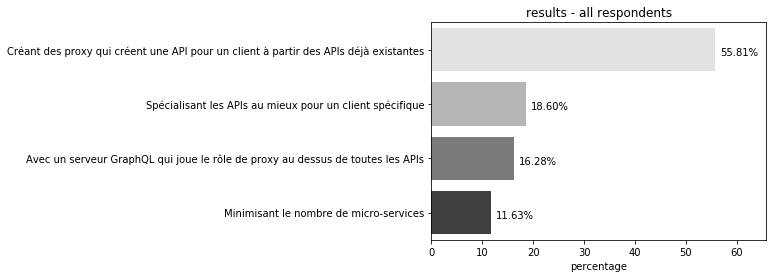

In [462]:
question = studied_data_set.columns[16]
print(question)

dataset = studied_data_set[question].dropna()
data = with_percentage_respondants(flatten_results(dataset), len(dataset))
data['results'] = data[question]
g = barplot_percentage(data, 'results', ' - all respondents')

#data_normalized = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question, ignore_others=True)
#data_normalized['results'] = data_normalized[question]
#data_normalized_with_others = flatten_and_compute_percentage_weighted_on_roles(studied_data_set, question)
#g = barplot_percentage(data_normalized, 'results', ' - all respondents, normalized along roles')